# Peaking emissions

* A key step on the way to reducing emissions is for them to peak, at both a national and global level
* This notebook reads in emissions data (either national totals or subsectors) and assesses how many countries have peaked. 
* The criteria for 'peaking' are as follows: 
    * a 'maxima' in emissions was reached 4 or more years before the end of the timeseries
    * over the last 5 years, emissions have decreased
    * [Optional] over the last 5 years, emissions have decreased by a certain amount?
    
    
TODO: 
* the current grouping has some overlaps!

    

In [48]:
# import modules

# system
import sys, os, re

# for analysis
import pandas as pd
import numpy as np

# for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn

# global stocktake tools
from gst_tools.make_plots import *
import gst_tools.gst_utils as utils

from shortcountrynames import to_name


In [86]:
# User specs

data_file_name = 'PRIMAP-hist_v2.0_Energy-CO2.csv'

assess_peaking_since_years = [1990, 2000]


In [87]:
# Read the data

# read the data from file 
fname_in = os.path.join('proc-data', data_file_name)
data = pd.read_csv(fname_in)

# extract the key information
variable = data['variable'].unique()[0]
unit = data['unit'].unique()[0]

data_years = utils.set_countries_as_index(data)
data_years = data_years.dropna(axis=1, how='any')

#TODO - add some checks / validation

# remove comment below to display the data
#data_years

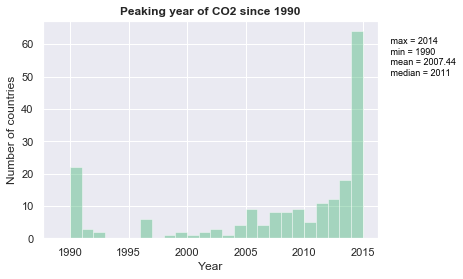

In [7]:
# Year of peaking

for year_since in assess_peaking_since_years:
    reduced_data = change_first_year(data_years, 2000)

    year_max = data_years.idxmax(axis=1)
    year_max = pd.to_numeric(year_max)
    year_max.name = 'peak year'

    start_year = min(list(map(int, data_years.columns)))
    end_year = max(list(map(int, data_years.columns)))

    make_histogram_peaking(year_max, variable, '', start_year, end_year, save_plot=False)
    

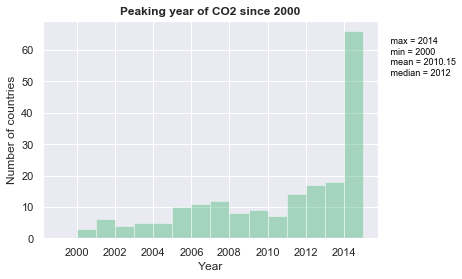

'\nNote that the above code could be re-used for any year, not just 2000. \n'

In [8]:
# Year of peaking since 2000

reduced_data = change_first_year(data_years, 2000)

year_max_2000 = reduced_data.idxmax(axis=1)
year_max_2000 = pd.to_numeric(year_max_2000)
year_max_2000.name = 'peak year'

start_year_2000 = min(list(map(int, reduced_data.columns)))
end_year_2000 = max(list(map(int, reduced_data.columns)))

make_histogram_peaking(year_max_2000, variable, '', start_year_2000, end_year_2000, save_plot=False)

"""
Note that the above code could be re-used for any year, not just 2000. 
"""
# TODO? - generalise the code to remove the '2000'. could then let the user specify the start year for counting! 

In [9]:
# part 3 - more nuanced version; what's the current trajectory?
# Fluctuating? Stalled? Or really decreasing? 

peaking_assessment = pd.DataFrame()
peaking_assessment['max year'] = year_max_2000
  
# Both of the options below work! If getting lots of boolean error issues, may just need to restart the kernel...

# Returns true for all countries that have their highest emissions BEFORE the last year of data
# Identfy countries that have 'peaked'
peaking_assessment['max_reached'] = peaking_assessment['max year'].apply(lambda x : (x < end_year_2000))

peaking_assessment['5year_peak'] = peaking_assessment['max year'].apply(
                                                                lambda x : (x < (end_year_2000 - 4)))

# identify countries with signficant decreasing trends
recent_trends, unit = calculate_trends(reduced_data, num_years_trend=5)
peaking_assessment['decreasing'] = recent_trends[str(end_year_2000)].apply(lambda x: (x < 0))
peaking_assessment['strongly_decreasing'] = recent_trends[str(end_year_2000)].apply(lambda x: (x < -2.5))

# sue multi-criteria to define different regimes
peaking_assessment['peaked'] = peaking_assessment['5year_peak'] & peaking_assessment['strongly_decreasing']
peaking_assessment['stabilised'] = peaking_assessment['5year_peak'] & peaking_assessment['decreasing']
peaking_assessment['possible'] = peaking_assessment['max_reached'] & peaking_assessment['decreasing']
peaking_assessment['not_peaked'] = (peaking_assessment['max_reached']== False) & (peaking_assessment['decreasing'] == False)
peaking_assessment['not max'] = (peaking_assessment['max_reached']== False)
  
# and use that to get some stats
share_peaked = peaking_assessment['peaked'].value_counts(normalize=True) 
share_stabilised = peaking_assessment['stabilised'].value_counts(normalize=True)
share_possible   = peaking_assessment['possible'].value_counts(normalize=True)
share_increasing = peaking_assessment['not_peaked'].value_counts(normalize=True)
share_not_max = peaking_assessment['not max'].value_counts(normalize=True)

# and print to screen...
print('')
print('Share of countries peaked is {:.1f}%'.format(share_peaked[True]*100))
print('Share of countries stabilised is {:.1f}%'.format(share_stabilised[True]*100))
print('Share of countries possibly stabilised is {:.1f}%'.format(share_possible[True]*100))
print('Share of countries still increasing is {:.1f}%'.format(share_increasing[True]*100))
print('Share of countries not at max value is {:.1f}%'.format(share_not_max[True]*100))
print('')


Averaging trend over 5 years.

Share of countries peaked is 13.8%
Share of countries stabilised is 25.6%
Share of countries possibly stabilised is 30.8%
Share of countries still increasing is 33.8%
Share of countries not at max value is 33.8%



In [85]:
# Also need to check the results! 

# 1. Peaking
# prep data for plotting (hack conversion to Mt...?)
peaked_country_trends = recent_trends[peaking_assessment['peaked']]
peaked_country_abs = data_years[peaking_assessment['peaked']] / 1000

# make the plots
plot_facet_grid_countries(peaked_country_trends, 'year', '% change', 
                          main_title='Countries with peaked emissions', 
                          save_plot=True)

plot_facet_grid_countries(peaked_country_abs, 'year', 'emissions', 
                          main_title='absolute emissions for peaked countries', 
                          save_plot=True)

    
# 2. Stabilised
stab_trends = recent_trends[peaking_assessment['stabilised']]
stab_abs    = data_years[peaking_assessment['stabilised']] / 1000

plot_facet_grid_countries(stab_trends, 'year', '% change', 
                         main_title='Trends in countries with stabilised emissions', 
                         save_plot=True)
plot_facet_grid_countries(stab_abs, 'year', 'emissions', 
                         main_title='Emissions in countries with stabilised emissions', 
                         save_plot=True)
    
# possibly stabilised
poss_stab_trends = recent_trends[peaking_assessment['possible']]
poss_stab_abs    = data_years[peaking_assessment['possible']] / 1000

plot_facet_grid_countries(poss_stab_trends, 'year', '% change', 
                         main_title='Trends in countries with possibly stabilised emissions', 
                         save_plot=True)
plot_facet_grid_countries(poss_stab_abs, 'year', 'emissions', 
                         main_title='Emissions in countries with possibly stabilised emissions', 
                         save_plot=True)

# still increasing
not_peaked_trends = recent_trends[peaking_assessment['not_peaked']]
not_peaked_abs    = data_years[peaking_assessment['not_peaked']] / 1000

plot_facet_grid_countries(not_peaked_trends, 'year', '% change', 
                         main_title='Trends in countries with emissions that have not yet peaked',
                         plot_name='not-peaked',
                         save_plot=True)
plot_facet_grid_countries(not_peaked_abs, 'year', 'emissions', 
                         main_title='Emissions in countries with emissions that have note yet peaked', 
                         plot_name='not-peaked',
                         save_plot=True)

# TODO - avoid overwriting plots - needs a better naming system!

In [82]:
def make_histogram_peaking(df, var, unit_, start_year, end_year, save_plot=False):
    
    """
    This is based on the make_simple_histogram function but caters to data that 
    contains both positive and negative values. For the GST, it's important to be 
    able to see whether or not trends etc. are positive or negative and a symmetric
    binning approach is needed. 
    
    To calculate the bin sizes, we use a couple of conditional rules based on the data
    available, including the max and min of the data and the number of data points. 
    For most plots we are expecting around 200 countries, but could also be a few regions. 
    
    TODO - 'df' is actually a series -> better name?
    """
    
    # Check the data - needs to not be, for example, all zeros
    if len(df.unique()) == 1:
        print('---------')
        print('All values in the series are the same! Exiting plotting routine for ' + str(var))
        print('---------')
        return
    
    # set a style
    sns.set(style="darkgrid") 
    
    
    # STATS
    # get some basic info about the data to use for setting styles, calculating bin sizes, and annotating plot
    maximum = int(max(df))
    minimum = int(min(df))
    mean = np.mean(df)
    median = np.median(df)
    npts = len(df) 

    # determine bin edges - annual!
    bin_width = 1 
    bins_calc = range((start_year-1), (end_year + 2), bin_width)                        
        
           
    # --------------        
    # MAKE THE PLOT
    
    # set up the figure
    fig, axs = plt.subplots()

    # make histogram
    sns.distplot(df, kde=False,
                 bins=bins_calc,
                 rug=False,   # with bins fixed at annual, the rugs aren't additional 
                 color='mediumseagreen',
                 rug_kws={"color": "rebeccapurple", "alpha": 0.7, "linewidth": 0.4, "height": 0.03})

    # Dynamically set x axis range to make symmetric abut 0
    if minimum < 0:
        # get and reset xmin or xmax
        xmin, xmax = axs.get_xlim()
        if np.absolute(xmax) > np.absolute(xmin):
            plt.xlim(-xmax, xmax)
        else:
            plt.xlim(xmin, -xmin)
        
        # and add a line at 0
        axs.axvline(linewidth=1, color='k')
           
    # Annotate the plot with stats
    axs.annotate((" max = {:.0f}".format(maximum) + 
                  "\n min = {:.0f}".format(minimum) + 
                  "\n mean = {:.2f}".format(mean) + 
                  "\n median = {:.0f}".format(median)),
                xy=(1.03, 0.75), xycoords=axs.transAxes,
                fontsize=9, color='black', 
                bbox=dict(facecolor='white', alpha=0.75))
    
    # label axes and add title
    axs.set_xlabel('Year')
    axs.set_ylabel('Number of countries')
    axs.set_title(('Peaking year of ' + var + ' since ' + str(start_year)), fontweight='bold')
    
    # show the plot
    plt.show()
    
    # save to file
    if save_plot:
        filepath = os.path.join('output', 'plots')
        fname = ('basic_histogram-' + var + '.pdf')
        if not os.path.exists(filepath):
            os.makedirs(filepath)
        filename = os.path.join(filepath, fname)
        plt.savefig(filename, format='pdf')
        plt.close()

def change_first_year(df, new_start_year):

    # reduce the number of years (keeps things lighter and faster)
    year_cols = [y for y in df[df.columns] if (re.match(r"[0-9]{4,7}$", str(y)) is not None)]
    other_cols = list(set(df.columns) - set(year_cols))

    # set other columns as index
    if other_cols:
        df = df.set_index(other_cols)
    
    # identify which years to keep 
    last_year = max(year_cols)
    years_to_keep = np.arange(new_start_year, (int(last_year)+1), 1)
    years_keep_str = list(map(str, years_to_keep))

    # remove extra years
    df = df.loc[:, years_keep_str]

    # return other columns
    if other_cols:
        df = df.set_index(other_cols)
    # TODO - modify so that the output index is the same as the input!
    
    return df
        

# below also used elsewhere, add to utils!
def calculate_trends(df, num_years_trend=10): 
    
    # disp average used for trend
    print('Averaging trend over ' + str(num_years_trend) + ' years.')
    
    # calculate annual % changes
    df_perc_change = df.pct_change(axis='columns') * 100
    new_unit = '%'
    
    # average over a window
    df_rolling_average = df_perc_change.rolling(window=num_years_trend, axis='columns').mean()
    
    return df_rolling_average, new_unit


def plot_facet_grid_countries(df, variable, value, main_title='', save_plot=False):
    
    # First, get some idea of the data so that it's easier to make clean plots
    ranges = df.max(axis=1) - df.min(axis=1)
    check = (ranges.max() - ranges.min()) / ranges.min()
    if abs(check) < 5:
        yshare = True
    else: 
        yshare = False
    
    # set up the df for plotting
    year_cols = df.columns
    dftomelt = df.reset_index()
    dftomelt['country'] = dftomelt['country'].apply(to_name)
    dfmelt = pd.melt(dftomelt, id_vars=['country'], 
                     value_vars=year_cols, var_name=variable, value_name=value)

    # set up the grid
    grid = sns.FacetGrid(dfmelt, col='country', palette="tab20c", sharey=yshare, 
                         col_wrap=4, aspect=1)

    # make the actual plots
    grid.map(sns.lineplot, variable, value, color="rebeccapurple")

    # Give subplots nice titles
    grid.set_titles(col_template = '{col_name}')
    
    # tidy up a bit
    for ax in grid.axes.flat:
        ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(4, prune="both"))
        ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(4, prune="both"))
        ax.axhline(0, color='k')
    if yshare:
        grid.fig.subplots_adjust(hspace=.15, wspace=.1, top=.95)
    else:
        grid.fig.subplots_adjust(hspace=.15, wspace=.25, top=.95)
        
    # give the whole plot a title
    grid.fig.suptitle(main_title, fontweight='bold', fontsize=15)

    if save_plot:
        filepath = os.path.join('output', 'plots')
    # grid.map(horiz_zero_line)
        fname = ('facetgrid-' + variable + '-' + value  + '.pdf')
        if not os.path.exists(filepath):
            os.makedirs(filepath)
        filename = os.path.join(filepath, fname)
        plt.savefig(filename, format='pdf')
        plt.close()
        